<a href="https://colab.research.google.com/github/coldjoke123/python1/blob/master/0517.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import Input, Lambda
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


# 讀入Mnist資料

In [0]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [0]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

x_test -= x_test.min()
x_test = x_test/x_test.max()

## VAE建立

In [0]:
enc_1 = Dense(500, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(500, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [6]:
x = Input(shape=(784,))

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var/2)*epsilon

In [0]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
x_hat = dec_1(dec_2(z))

In [10]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1002        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            1002        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

# Loss function

In [0]:
def vae_loss(x, x_recon):
    recoery_loss = 784*metrics.binary_crossentropy(x, x_recon)
    KL_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    return recoery_loss + KL_loss

In [0]:
VAE.compile(loss = vae_loss, optimizer=Adam(lr = 1e-4))

In [13]:
VAE.fit(x_train, x_train, batch_size=32, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 29s 486us/step - loss: 216.0060
Epoch 2/10
60000/60000 [==============================] - 29s 482us/step - loss: 192.2146
Epoch 3/10
60000/60000 [==============================] - 30s 495us/step - loss: 184.1294
Epoch 4/10
60000/60000 [==============================] - 30s 496us/step - loss: 181.4126
Epoch 5/10
60000/60000 [==============================] - 31s 511us/step - loss: 180.5536
Epoch 6/10
60000/60000 [==============================] - 30s 500us/step - loss: 180.0533
Epoch 7/10
60000/60000 [==============================] - 30s 504us/step - loss: 179.8085
Epoch 8/10
60000/60000 [==============================] - 30s 508us/step - loss: 179.6135
Epoch 9/10
60000/60000 [==============================] - 30s 495us/step - loss: 179.4560
Epoch 10/10
60000/60000 [==============================] - 30s 494us/step - loss: 179.3017


In [14]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1002      
Total params: 393,502
Trainable params: 393,502
Non-trainable params: 0
_________________________________________________________________


In [15]:
h_input = Input(shape=(2,))
VAE_decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1500      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               392784    
Total params: 394,284
Trainable params: 394,284
Non-trainable params: 0
_________________________________________________________________


# 視覺化呈現 encoder 的部分

In [16]:
indices = np.random.randint(x_test.shape[0], size=1000)

VAE_latent = VAE_encoder.predict(x_train[indices])
VAE_latent.shape

(1000, 2)

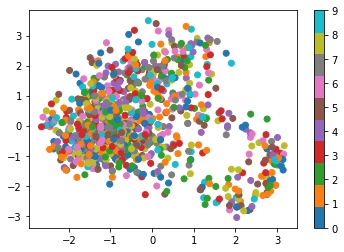

In [17]:
plt.scatter(VAE_latent[:,0],VAE_latent[:,1],c = y_test0[indices],cmap='tab10')
plt.colorbar()

# 視覺化呈現 decoder 的部分

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
vae_figure = np.zeros((digit_size*n,digit_size*n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array(  [  [xi,yi]  ]  )
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        vae_figure[(n-i-1)*digit_size:(n-i)*digit_size,
              j*digit_size:(j+1)*digit_size] = normalized(digit)

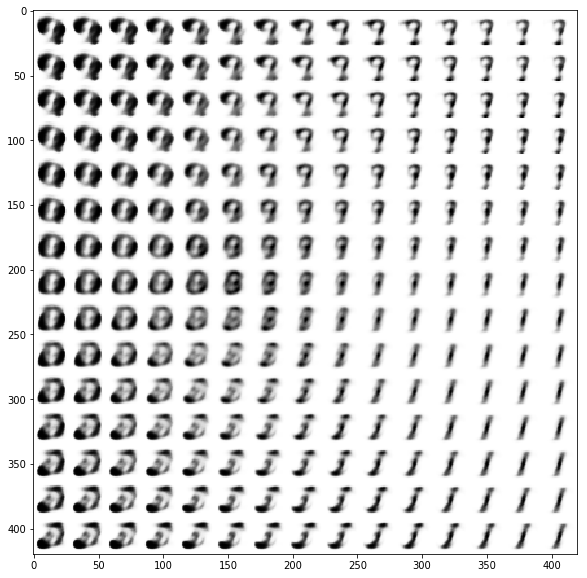

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(vae_figure, cmap='Greys')
plt.show()

## 以數值拉桿的方式動態比較

In [0]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(2,1,2)
    ax1.scatter(mu_0[0],mu_0[1])
    ax1.scatter(mu_1[0],mu_1[1])
    ax1.scatter(mu_t[0],mu_t[1])
    
    ax2 = plt.subplot(2,3,1)
    ax2.imshow(data_0, cmap='Greys')
    
    ax3 = plt.subplot(2,3,2)
    ax3.imshow(data_t, cmap='Greys')
    
    ax4 = plt.subplot(2,3,3)
    ax4.imshow(data_1, cmap='Greys')

In [0]:
idx_1, idx_2 = np.random.randint(10000,size=2)

In [23]:
interact(inBetween, t = FloatSlider(value=0.5, min = 0, max = 1.0, step = 0.02))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>